In [1]:
# Libraries
from dotenv import load_dotenv
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from torch.utils.data import Dataset
from glob import glob
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from typing import Optional
from tqdm import tqdm

# Initialization of the environment
# Load the variable from .env
pd.set_option('display.max_columns', None)
load_dotenv()
hf_access_token = os.getenv("HF_ACCESS_TOKEN")
cache_dir = os.getenv("CACHE_DIR")

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and tokenizer onto GPU
checkpoint = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir=cache_dir, token=hf_access_token)
model = AutoModelForCausalLM.from_pretrained(checkpoint, cache_dir=cache_dir, token=hf_access_token).to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
class ImportLLMfromHF:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

        # Ensure the tokenizer has a padding token
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def get_embd_size(self):
        return self.model.config.hidden_size

    def get_nb_layers(self):
        return self.model.config.num_hidden_layers

class LayersUnits:
    def __init__(self, llm: ImportLLMfromHF, data: Dataset, method: str = "average"):
        self.llm = llm
        self.data = data
        self.data_activation = None
        self.group = {"positive": 0, "negative": 1}
        self.method_fn = self.average_tokens_layers if method == "average" else self.final_tokens_layers if method == "final" else None
        self.name = type(data).__name__

        # Set tokenizer arguments based on dataset name
        self.tokenizer_args = {"return_tensors": "pt"}
        if self.name == "LangLocDataset":
            self.tokenizer_args.update({"truncation": True, "max_length": 12})

        self.extract_all_units()

    def reset_data_activation(self):
        embd_size = self.llm.get_embd_size()
        n_layers = self.llm.get_nb_layers()
        # Move the tensor to GPU
        self.data_activation = torch.zeros(2, len(self.data), embd_size, n_layers, device=device)

    def clear_hooks(self):
        for layer in self.llm.model.model.layers:
            layer._forward_hooks.clear()

    def reset(self):
        self.clear_hooks()
        self.reset_data_activation()

    def get_hook_layers(self, idx, activation):
        def hook_layers(module, input, output):
            activation[:, :, :, idx] = output[0].squeeze(0).to(device)
        return hook_layers

    def average_tokens_layers(self, activation):
        return activation.mean(dim=1)

    def final_tokens_layers(self, activation):
        return activation[:, -1, :, :]

    def extract_layer_units(self, idx, group_name="positive", method="average"):
        self.clear_hooks()
        self.llm.model.eval()

        prompt = self.data[idx][self.group[group_name]]
        inputs = self.llm.tokenizer(prompt, **self.tokenizer_args).to(device)
        
        n_tokens = inputs["input_ids"].shape[1]
        embd_size = self.llm.get_embd_size()
        n_layers = self.llm.get_nb_layers()
        
        activation = torch.zeros(1, n_tokens, embd_size, n_layers, device=device)

        for i, layer in enumerate(self.llm.model.model.layers):
            layer.register_forward_hook(self.get_hook_layers(i, activation))

        with torch.no_grad():
            self.llm.model(**inputs)

        return self.method_fn(activation)

    def extract_all_units(self):
        self.reset()
        for idx in range(len(self.data)):
            self.data_activation[0, idx, :, :] = self.extract_layer_units(idx, "positive")
            self.data_activation[1, idx, :, :] = self.extract_layer_units(idx, "negative")

In [4]:
def append_options(question):
    options = ["True", "False"]
    return f"{question}\nOptions:\n- {options[0]}\n- {options[1]}"

def read_story(path):
    with open(path, "r") as f:
        story = [line.strip() for line in f.readlines()]
    return ' '.join(story)

def read_question(path):
    with open(path, "r") as f:
        question = f.read().split('\n\n')[0]
    return append_options(question.replace("\n", ""))

class ToMLocDataset(Dataset):
    def __init__(self):
        instruction = "In this experiment, you will read a series of sentences and then answer True/False questions about them. Press button 1 to answer 'true' and button 2 to answer 'false'."
        context_template = "{instruction}\nStory: {story}\nQuestion: {question}\nAnswer: {answer}"
        belief_stories = [read_story(f"dataset/prompt/tomloc/{idx}b_story.txt") for idx in range(1, 11)]
        photograph_stories = [read_story(f"dataset/prompt/tomloc/{idx}p_story.txt") for idx in range(1, 11)]

        belief_question = [read_question(f"dataset/prompt/tomloc/{idx}b_question.txt") for idx in range(1, 11)]
        photograph_question = [read_question(f"dataset/prompt/tomloc/{idx}p_question.txt") for idx in range(1, 11)]

        self.positive = [context_template.format(instruction=instruction, story=story, question=question, answer=np.random.choice(["True", "False"])) for story, question in zip(belief_stories, belief_question)]
        self.negative = [context_template.format(instruction=instruction, story=story, question=question, answer=np.random.choice(["True", "False"])) for story, question in zip(photograph_stories, photograph_question)]

    def __getitem__(self, idx):
        return self.positive[idx].strip(), self.negative[idx].strip()
    
    def __len__(self):
        return len(self.positive)

class LangLocDataset(Dataset):
    def __init__(self):
        dirpath = "dataset/prompt/langloc"
        paths = glob(f"{dirpath}/*.csv")
        vocab = set()

        data = pd.read_csv(paths[0])
        for path in paths[1:]:
            run_data = pd.read_csv(path)
            data = pd.concat([data, run_data])

        data["sent"] = data["stim2"].apply(str.lower)

        vocab.update(data["stim2"].apply(str.lower).tolist())
        for stimuli_idx in range(3, 14):
            data["sent"] += " " + data[f"stim{stimuli_idx}"].apply(str.lower)
            vocab.update(data[f"stim{stimuli_idx}"].apply(str.lower).tolist())

        self.vocab = sorted(list(vocab))
        self.w2idx = {w: i for i, w in enumerate(self.vocab)}
        self.idx2w = {i: w for i, w in enumerate(self.vocab)}

        self.positive = data[data["stim14"]=="S"]["sent"].tolist()
        self.negative = data[data["stim14"]=="N"]["sent"].tolist()

    def __getitem__(self, idx):
        return self.positive[idx].strip(), self.negative[idx].strip()
        
    def __len__(self):
        return len(self.positive)

In [5]:
class LocImportantUnits:
    def __init__(self,
                 checkpoint,
                 layers_units: torch.Tensor):
        self.model_name = checkpoint.split("/")[-1]
        self.fb_group = layers_units[0].cpu()
        self.fp_group = layers_units[1].cpu()
        self.t_values = self.welch_test()
        self.ranked_units = self.get_ranked_units()

    def welch_test(self):
        n_units = self.fb_group.shape[1]
        n_layers = self.fb_group.shape[2]

        # Reshape for Welch t-test
        fb_flattened = np.abs(self.fb_group.reshape(self.fb_group.shape[0], -1))
        fp_flattened = np.abs(self.fp_group.reshape(self.fp_group.shape[0], -1))
        # Perform the t-test along the first axis (sample dimension)
        t_stat, _ = ttest_ind(fb_flattened, fp_flattened, axis=0, equal_var=False)
        print(t_stat.shape)

        # Reshape t_stat back to (units, n_layers)
        return t_stat.reshape(n_units, n_layers)
    
    def get_ranked_units(self):
        # Get ranked matrix
        flat = self.t_values.flatten()
        sorted_indices = np.argsort(flat)[::-1]  # Sort indices in descending order
        ranked = np.empty_like(sorted_indices)
        ranked[sorted_indices] = np.arange(1, len(flat) + 1)
        # Reshape the ranked values back to the original matrix shape
        return ranked.reshape(self.t_values.shape)
    
    def get_masked_ktop(self, percentage):
        num_top_elements = int(self.t_values.size * percentage)
        # Flatten the matrix, find the threshold value for the top 1%
        flattened_matrix = self.t_values.flatten()
        threshold_value = np.partition(flattened_matrix, -num_top_elements)[-num_top_elements]

        # Create a binary mask where 1 represents the top 1% elements, and 0 otherwise
        mask_units = np.where(self.t_values >= threshold_value, 1, 0)
        return mask_units
    
    def get_random_mask(self, percentage, seed=None):
        # Set the seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
        
        # Calculate the total number of units
        total_units = self.t_values.size
        num_units_to_select = int(total_units * percentage)
        
        # Create a flattened array of zeros
        mask_flat = np.zeros(total_units, dtype=int)
        
        # Randomly select indices and set them to 1
        selected_indices = np.random.choice(total_units, num_units_to_select, replace=False)
        mask_flat[selected_indices] = 1
        
        # Reshape the mask back to the original shape
        return mask_flat.reshape(self.t_values.shape)
    
    def plot_layer_percentages(self, percentage, mask_type='ktop', seed=None, save_path=None):
        """
        Plots the percentage of important units per layer.
        
        Parameters:
        - percentage (float): The top percentage of units to be considered as important.
        - mask_type (str): Type of mask to use ('ktop' for k-top mask or 'random' for random mask).
        - seed (int, optional): Random seed for reproducibility when using the random mask.
        - save_path (str, optional): Path to save the plot. If None, shows the plot.
        """
        
        # Generate the mask based on the specified mask type
        if mask_type == 'ktop':
            mask = self.get_masked_ktop(percentage)
        elif mask_type == 'random':
            mask = self.get_random_mask(percentage, seed=seed)
        else:
            raise ValueError("Invalid mask_type. Choose 'ktop' or 'random'.")
        
        # Calculate the percentage of important units for each layer
        layer_percentages = [(np.sum(layer) / layer.size) * 100 for layer in mask.T]

        # Convert to a column vector for plotting
        layer_percentages_matrix = np.array(layer_percentages).reshape(-1, 1)

        # Plot the layer percentages as a matrix with shape (number of layers, 1)
        plt.figure(figsize=(2, 8))
        cmap = plt.get_cmap('viridis')
        norm = Normalize(vmin=min(layer_percentages), vmax=max(layer_percentages))
        plt.imshow(layer_percentages_matrix, cmap=cmap, aspect='auto')
        plt.colorbar(label="Percentage of Important Units")
        plt.title(f"Percentage of Important Units per Layer ({mask_type.capitalize()} Mask, Top {percentage*100:.1f}%)")
        plt.xlabel("Layer")
        plt.ylabel("Percentage")

        # Add text annotations with adaptive color based on background brightness
        for i, perc in enumerate(layer_percentages):
            color = cmap(norm(perc))
            brightness = 0.3 * color[0] + 0.5 * color[1] + 0.2 * color[2]
            text_color = "white" if brightness < 0.5 else "black"
            plt.text(0, i, f"{perc:.1f}%", ha="center", va="center", color=text_color)

        # Configure ticks
        plt.yticks(range(len(layer_percentages)), [f"Layer {i+1}" for i in range(len(layer_percentages))])
        plt.xticks([])

        # Save the plot or show it based on the save_path parameter
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Plot saved as {save_path}")
        else:
            plt.show()

In [6]:
class AblateUnits:
    def __init__(self, llm: ImportLLMfromHF, mask: Optional[np.ndarray] = None):
        self.llm = llm
        self.mask = mask
        self.layer_outputs = []

    def clear_hooks(self):
        for layer in self.llm.model.model.layers:
            layer._forward_hooks.clear()

    def get_hook_ablate(self, idx):
        def hook_ablate(module, input, output):
            mask_layer = self.mask[idx]
            unit_indices = mask_layer.nonzero()
            output[0][:,:,unit_indices] = 0
            self.layer_outputs.append(output[0].clone().to(device))
        return hook_ablate

    def ablate_units(self, prompt):
        self.clear_hooks()
        self.layer_outputs.clear()
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        for idx, layer in enumerate(self.llm.model.model.layers):
            layer.register_forward_hook(self.get_hook_ablate(idx))

        with torch.no_grad():
            generated_tokens = self.llm.model.generate(**inputs, max_length=50, do_sample=True, top_p=0.95, top_k=50)

        decoded_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
        return decoded_text

(131072,)


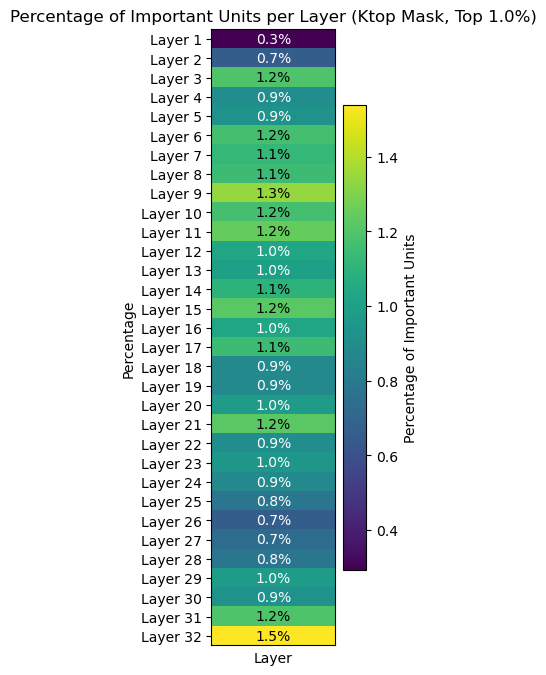

In [7]:
# Initialize model and localizer classes only once per session
lang_data = LangLocDataset()
tom_data = ToMLocDataset()
llm = ImportLLMfromHF(model, tokenizer)
units = LayersUnits(llm, tom_data)
loc_units = LocImportantUnits(checkpoint, units.data_activation)
mask = loc_units.get_masked_ktop(0.01)
# perturbation = AblateUnits(llm, mask.T)
# perturbation.ablate_units("Hello! What it the capital of France?")
loc_units.plot_layer_percentages(0.01)

In [8]:
class EvaluateBenchmark:
    def __init__(self,
                llm: ImportLLMfromHF,
                loc_units: LocImportantUnits,
                batch_size: int=20):
        self.llm = llm
        self.loc_units = loc_units
        self.batch_size = batch_size

        # Ensure the tokenizer has a padding token
        if self.llm.tokenizer.pad_token is None:
            self.llm.tokenizer.pad_token = self.llm.tokenizer.eos_token
    
    def clear_hooks(self):
        for layer in self.llm.model.model.layers:
            layer._forward_hooks.clear()

    def get_hook_ablate(self, idx, mask):
        def hook_ablate(module, input, output):
            mask_layer = mask[idx]
            unit_indices = mask_layer.nonzero()
            output[0][:,:,unit_indices] = 0
        return hook_ablate
    
    def get_generated_tokens(self, outputs, input_length):
        # Slice generated tokens to exclude the initial prompt tokens
        generated_texts = []
        for output in outputs:
            new_tokens = output[input_length:]  # Exclude prompt tokens
            generated_texts.append(tokenizer.decode(new_tokens, skip_special_tokens=True))
        return generated_texts

    def generate_text_with_ablations(self, prompts, mask, **generate_kwargs):
        self.clear_hooks()
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, padding_side="left", truncation=True).to(self.llm.model.device)
        input_length = inputs['input_ids'].shape[1]  # Get the length of the prompt tokens
        for idx, layer in enumerate(self.llm.model.model.layers):
            layer.register_forward_hook(self.get_hook_ablate(idx, mask))

        with torch.no_grad():
            outputs = self.llm.model.generate(**inputs, max_new_tokens=12, **generate_kwargs)

        # Slice generated tokens to exclude the initial prompt tokens
        return self.get_generated_tokens(outputs, input_length)
    
    def generate_text_without_ablation(self, prompts, **generate_kwargs):
        self.clear_hooks()
        self.llm.model.eval()
        inputs = self.llm.tokenizer(prompts, return_tensors="pt", padding=True, padding_side="left", truncation=True).to(self.llm.model.device)
        input_length = inputs['input_ids'].shape[1]  # Get the length of the prompt tokens
        with torch.no_grad():
            outputs = self.llm.model.generate(**inputs, max_new_tokens=12, **generate_kwargs)

        # Slice generated tokens to exclude the initial prompt tokens
        return self.get_generated_tokens(outputs, input_length)
     
    def generate(self, prompts, mask=None):
        # Set temperature to 0 for deterministic generation
        generation_config = {
            "temperature": None,          # Explicitly unset temperature
            "top_p": None,   
            "do_sample": False,  # Ensures deterministic generation
            "pad_token_id": tokenizer.eos_token_id  # Set the padding token if necessary
        }

        if mask is None:
            return self.generate_text_without_ablation(prompts, **generation_config)
        else:
            return self.generate_text_with_ablations(prompts, mask, **generation_config)
        
    def compute_surprisal(self, prompt: str, candidates: list):
        """
        Computes surprisal values for a list of candidate completions given a prompt.
        
        Args:
            prompt (str): The prompt for the language model.
            candidates (list): A list of candidate completions.
            llm (ImportLLMfromHF): Model and tokenizer wrapper.

        Returns:
            str: The candidate with the lowest surprisal score.
        """
        # Determine device (GPU if available)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.llm.model.to(device)

        # Tokenize the prompt
        candidates_surprisal = []
        prompt_inputs = self.llm.tokenizer(prompt, return_tensors="pt").to(device)
        
        for candidate in candidates:
            # Tokenize candidate
            candidate_inputs = self.llm.tokenizer(candidate, return_tensors="pt").to(device)

            # Concatenate prompt and candidate tokens
            input_ids = torch.cat([prompt_inputs["input_ids"], candidate_inputs["input_ids"][:, 1:]], dim=-1).to(device)

            # Get logits from the model
            with torch.no_grad():
                outputs = llm.model(input_ids)
            logits = outputs.logits

            # Extract logits for the candidate tokens
            start_idx = prompt_inputs["input_ids"].shape[1]
            candidate_logits = logits[0, start_idx:, :]

            # Calculate negative log-probability (surprisal) for each candidate token
            candidate_logprobs = []
            for i, token_id in enumerate(candidate_inputs["input_ids"][0, 1:]):
                token_logits = candidate_logits[i]
                token_logprob = torch.log_softmax(token_logits, dim=-1)[token_id]
                candidate_logprobs.append(-token_logprob.item())  # negative log-probability as surprisal

            # Average surprisal for the candidate
            avg_surprisal = np.mean(candidate_logprobs)
            candidates_surprisal.append(avg_surprisal)

        # Find the candidate with the lowest surprisal score
        min_surprisal_index = np.argmin(candidates_surprisal)
        return candidates[min_surprisal_index]
    
    
    def experiment(self, df, pct=0.01):
        """  """
        data = df.copy()
        assess_dict = {
            "no_ablation": None,
            f"ablate_top_{pct*100}": self.loc_units.get_masked_ktop(pct).T,
            f"ablate_random1_{pct*100}": self.loc_units.get_random_mask(pct).T,
            f"ablate_random2_{pct*100}": self.loc_units.get_random_mask(pct).T,
            f"ablate_random3_{pct*100}": self.loc_units.get_random_mask(pct).T 
        }

        for key, mask in assess_dict.items():
            # Generate responses in batches and collect results
            predict_cands = []
            for i in tqdm(range(0, len(data), self.batch_size)):
                batch_prompts = data["prompt"].iloc[i:i+self.batch_size].tolist()
                predict_cands.extend(self.generate(batch_prompts, mask))
            
            data[f"predict_{key}"] = predict_cands
        return data

In [9]:
import torch
import numpy as np
from tqdm import tqdm

class AssessBenchmark:
    def __init__(self,
                 llm: ImportLLMfromHF,
                 loc_units: LocImportantUnits,
                 batch_size: int = 20):
        self.llm = llm
        self.loc_units = loc_units
        self.batch_size = batch_size

        if self.llm.tokenizer.pad_token is None:
            self.llm.tokenizer.pad_token = self.llm.tokenizer.eos_token

    def clear_hooks(self):
        """Clears all registered forward hooks in the model layers."""
        for layer in self.llm.model.model.layers:
            layer._forward_hooks.clear()
    
    def get_hook_ablate(self, idx, mask):
        """
        Defines a hook function to ablate specific units based on a mask.
        
        Args:
            idx (int): Layer index.
            mask (torch.Tensor): Binary mask for ablation at the given layer.

        Returns:
            function: A hook function to zero out specified units.
        """
        def hook_ablate(module, input, output):
            mask_layer = mask[idx]
            unit_indices = mask_layer.nonzero()
            output[0][:, :, unit_indices] = 0
        return hook_ablate

    def surprisal(self, prompts, candidates_list, mask=None):
        """
        Computes surprisal for each candidate completion in a batch of prompts and returns
        the candidate with the lowest surprisal for each prompt.
        
        Args:
            prompts (list): List of prompt strings.
            candidates_list (list of lists): List of candidate lists for each prompt.
            mask (optional): Mask for ablation.

        Returns:
            list: A list where each element is the candidate with the lowest surprisal for each prompt.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.llm.model.to(device)
        self.clear_hooks()
        
        if mask is not None:
            for idx, layer in enumerate(self.llm.model.model.layers):
                layer.register_forward_hook(self.get_hook_ablate(idx, mask))

        # Tokenize prompts in a batch
        prompt_inputs = self.llm.tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(device)
        surprisal_results = []

        for prompt_input, candidates in zip(prompt_inputs["input_ids"], candidates_list):
            candidate_surprisals = []

            # Process each candidate individually for the current prompt
            for candidate in candidates:
                candidate_input = self.llm.tokenizer(candidate, return_tensors="pt").to(device)
                # Concatenate the prompt and candidate tokens
                input_ids = torch.cat([prompt_input.unsqueeze(0), candidate_input["input_ids"][:, 1:]], dim=-1).to(device)

                with torch.no_grad():
                    outputs = self.llm.model(input_ids)
                logits = outputs.logits

                # Extract logits for the candidate tokens
                start_idx = prompt_input.shape[0]
                candidate_logits = logits[0, start_idx:, :]

                # Calculate negative log-probability (surprisal) for each token in the candidate
                candidate_logprobs = []
                for i, token_id in enumerate(candidate_input["input_ids"][0, 1:]):
                    token_logits = candidate_logits[i]
                    token_logprob = torch.log_softmax(token_logits, dim=-1)[token_id]
                    candidate_logprobs.append(-token_logprob.item())

                # Calculate average surprisal for the candidate and store it
                avg_surprisal = np.mean(candidate_logprobs)
                candidate_surprisals.append(avg_surprisal)

            # Find the index of the candidate with the lowest surprisal
            min_index = np.argmin(candidate_surprisals)
            surprisal_results.append(candidates[min_index])

        self.clear_hooks()  # Clear hooks after computation
        return surprisal_results

    def experiment(self, df, pct=0.01):
        """
        Run an experiment on a DataFrame of prompts to evaluate surprisal scores
        with and without ablations.
        
        Args:
            df (DataFrame): The DataFrame containing the prompts and candidates.
            pct (float): The percentage of top units to ablate in some settings.

        Returns:
            DataFrame: The original DataFrame with added columns for surprisal scores.
        """
        data = df.copy()
        
        # Define different ablation masks for comparison
        assess_dict = {
            "no_ablation": None,
            # f"ablate_top_{int(pct * 100)}": self.loc_units.get_masked_ktop(pct).T,
            # f"ablate_random1_{int(pct * 100)}": self.loc_units.get_random_mask(pct).T,
            # f"ablate_random2_{int(pct * 100)}": self.loc_units.get_random_mask(pct).T,
            # f"ablate_random3_{int(pct * 100)}": self.loc_units.get_random_mask(pct).T 
        }

        # For each ablation setting, compute surprisal scores
        for key, mask in assess_dict.items():
            surprisal_scores = []
            for i in tqdm(range(0, len(data), self.batch_size), desc=f"Processing {key}"):
                # Fetch a batch of prompts and corresponding candidates
                batch_prompts = data["prompt"].iloc[i:i+self.batch_size].tolist()
                batch_candidates = data["cands"].iloc[i:i+self.batch_size].tolist()
                
                # Calculate surprisal scores for each prompt and its list of candidates
                batch_scores = self.surprisal(batch_prompts, batch_candidates, mask)
                surprisal_scores.extend(batch_scores)
            
            # Store the surprisal scores for each ablation setting
            data[f"predict_{key}"] = surprisal_scores

        return data

In [59]:
import ast
class BenchmarkToMi(Dataset):
    def __init__(self):
        csv_file="dataset/benchmarks/ToMi/ToMi-finalNeuralTOM.csv"
        df = pd.read_csv(csv_file)
        df = df[df["qOrder"]=='first_order'].reset_index(drop=True)
        # Convert the 'cands' column from string representation of lists to actual lists
        df["cands"] = df["cands"].apply(ast.literal_eval)
        context = (
            "The following multiple choice question is based on the following story. The question "
            "is related to Theory-of-Mind. Read the story and then answer the questions. Choose the best answer "
            "from the options provided by printing it as is without any modifications."
        )
        instruction = "In this experiment, you will read a series of sentences and then answer True/False questions about them. Press button 1 to answer 'true' and button 2 to answer 'false'."

        df["prompt"] = df.apply(
            lambda row: f"{context}\nStory: {row["story"]}\nQuestion: {row["question"]}\nOptions:\n- {row["cands"][0]}\n- {row["cands"][1]}\nAnswer:",
            axis=1
        )
        # df = df.iloc[:20]
        self.data = df
        self.expanded_df = pd.DataFrame({
            "id_prompt": self.data.index.repeat(self.data["cands"].str.len()),
            "id_cand": [i for sublist in self.data["cands"] for i in range(len(sublist))],
            "cand": [cand for cands in self.data["cands"] for cand in cands],
            "fusion": [f"{prompt}{cand}" for prompt, cands in zip(self.data["prompt"], self.data["cands"]) for cand in cands],
            "prompt_end_pos": [
                len(prompt) for prompt, cands in zip(self.data["prompt"], self.data["cands"]) for _ in cands
            ]
        })

        # Tokenize the "fusion" variable starting from "prompt_end_pos"
        self.expanded_df["last_tokens"] = self.expanded_df.apply(
            lambda row: tokenizer(row["fusion"][row["prompt_end_pos"]:], add_special_tokens=False)["input_ids"], axis=1
        ).apply(len)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.expanded_df)

    def __getitem__(self, idx):
        """
        Fetches a single data point from the dataset.
        
        Args:
            idx (int): Index of the data point.
        
        Returns:
            dict: A dictionary containing the data for the specified index.
        """
        row = self.expanded_df.iloc[idx]
        return {
            "id_prompt": row["id_prompt"],
            "id_cand": row["id_cand"],
            "cand": row["cand"],
            "fusion": row["fusion"],
            "prompt_end_pos": row["prompt_end_pos"]
        }

def compute_cand_score(row):
        logits = row['last_embds']
        n = row['last_tokens']
        if n == 1:
            return logits[-1]  # Return the last element
        elif n > 1:
            return sum(logits[-n:]) / n  # Return the mean of the last N elements

class AssessBenchmark:
    def __init__(self,
                 llm: ImportLLMfromHF,
                 loc_units: LocImportantUnits,
                 batch_size: int = 20):
        self.llm = llm
        self.batch_size = batch_size
        self.loc_units = loc_units

        if self.llm.tokenizer.pad_token is None:
            self.llm.tokenizer.pad_token = self.llm.tokenizer.eos_token
    
    def clear_hooks(self):
        """Clears all registered forward hooks in the model layers."""
        for layer in self.llm.model.model.layers:
            layer._forward_hooks.clear()
    
    def get_hook_ablate(self, idx, mask):
        """
        Defines a hook function to ablate specific units based on a mask.
        
        Args:
            idx (int): Layer index.
            mask (torch.Tensor): Binary mask for ablation at the given layer.

        Returns:
            function: A hook function to zero out specified units.
        """
        def hook_ablate(module, input, output):
            mask_layer = mask[idx]
            unit_indices = mask_layer.nonzero()
            output[0][:, :, unit_indices] = 0
        return hook_ablate
    
    def assess(self, 
               data: pd.DataFrame,
               mask: Optional[np.ndarray] = None):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.llm.model.to(device)
        self.clear_hooks()

        if mask is not None:
            for idx, layer in enumerate(self.llm.model.model.layers):
                layer.register_forward_hook(self.get_hook_ablate(idx, mask))

        exp_df = data.copy()
        max_num_tokens = exp_df["last_tokens"].max()

        surprisal = []
        last_decoded_tokens = []
        all_final_positions = []

        for i in tqdm(range(0, len(exp_df), self.batch_size)):
            batch_texts = exp_df["fusion"].tolist()[i:i+self.batch_size]
            # Tokenize the batch of texts and get input IDs
            inputs = self.llm.tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)

            with torch.no_grad():
                outputs = self.llm.model(**inputs)

            last_token_positions = (inputs["attention_mask"].sum(dim=1) - 1)
            # Define a range of offsets for the last tokens
            expanded_positions = last_token_positions[:, None] - torch.arange(max_num_tokens, -1, -1, device=device)
            token_positions = torch.gather(inputs["input_ids"], 1, expanded_positions)
            batch_indices = torch.arange(inputs["input_ids"].shape[0]).unsqueeze(1).expand(-1, max_num_tokens+1)
            outputs_softmax = torch.softmax(outputs.logits, dim=-1)
            selected_softmax = outputs_softmax[batch_indices, expanded_positions, token_positions]
            selected_surprisal = -torch.log(selected_softmax + 1e-8)

            batch_decoded_tokens = [tokenizer.convert_ids_to_tokens(row.tolist()) for row in token_positions]

            surprisal.extend(selected_surprisal.cpu().numpy())
            last_decoded_tokens.extend(batch_decoded_tokens)
            all_final_positions.extend(token_positions.cpu().numpy())

        exp_df["last_embds"] = surprisal
        exp_df["last_decoded_tokens"] = last_decoded_tokens
        exp_df["last_pos"] = all_final_positions
        exp_df["score_cand"] = exp_df.apply(compute_cand_score, axis=1)

        # return exp_df

        # Group by 'id_prompt' and find the row with the minimum surprisal for each group
        best_cand_df = exp_df.loc[exp_df.groupby('id_prompt')['score_cand'].idxmin()]
        # Reset the index if necessary
        best_cand_df = best_cand_df.reset_index(drop=True)
        subset = best_cand_df[["id_prompt", "cand"]]
        return subset
    
    def experiment(self, 
                   bn_data: BenchmarkToMi,
                   pct=0.01):
        assess_dict = {
            "no_ablation": None,
            f"ablate_top_{int(pct * 100)}": self.loc_units.get_masked_ktop(pct).T,
            # f"ablate_random1_{int(pct * 100)}": self.loc_units.get_random_mask(pct).T,
            # f"ablate_random2_{int(pct * 100)}": self.loc_units.get_random_mask(pct).T,
            # f"ablate_random3_{int(pct * 100)}": self.loc_units.get_random_mask(pct).T 
        }
        df = bn_data.data.copy()
        df = df.reset_index()
        for key, mask in assess_dict.items():
            subset = self.assess(bn_data.expanded_df, mask)
            df = df.merge(subset, left_on="index", right_on="id_prompt", how="left")
            df = df.rename(columns={"cand": f"predict_{key}"})
            df = df.drop(columns=["id_prompt"]) 
        return df


bn_tomi = BenchmarkToMi()
bn_assess = AssessBenchmark(llm, loc_units)
res = bn_assess.experiment(bn_tomi)
res.head(4)

  0%|          | 0/62 [00:00<?, ?it/s]

100%|██████████| 62/62 [00:55<00:00,  1.12it/s]


,index,story,question,answer,i,dataGenSeq,sType,qTypeRaw,qTypeTomOrNot,qOrder,storyHasToM,answerMem,answerReal,qToMandOmniReader,answerMemOrReal,cands,correct,falseTrueBelief,factVsMind,prompt,predict_no_ablation,predict_ablate_top_1
0,0,Jack entered the laundry. Logan entered the st...,Where will Jack look for the persimmon?,bucket,1,"enter_agent_0,agent_2_enters,enter_agent_1,age...",second_order_false_belief,first_order_0_no_tom,False,first_order,False,pantry,bucket,False,reality,"[pantry, bucket]",1,True,mind,The following multiple choice question is base...,bucket,bucket
1,1,Ella entered the dining room. Carter entered t...,Where will Ella look for the lemon?,drawer,1,"enter_agent_1,enter_agent_0,agent_1_exits,agen...",false_belief,first_order_0_tom,True,first_order,True,drawer,pantry,False,memory,"[pantry, drawer]",1,False,mind,The following multiple choice question is base...,drawer,drawer
2,2,Mason entered the bedroom. Isabella entered th...,Where will Mason look for the pineapple?,crate,1,"enter_agent_0,enter_agent_1,agent_2_enters,age...",second_order_false_belief,first_order_0_no_tom,False,first_order,False,bottle,crate,False,reality,"[bottle, crate]",1,True,mind,The following multiple choice question is base...,bottle,bottle
3,3,Mason entered the sunroom. Ella entered the su...,Where will Mason look for the lemon?,bottle,1,"enter_agent_0,enter_agent_1,agent_1_exits,agen...",false_belief,first_order_0_no_tom,False,first_order,False,bathtub,bottle,False,reality,"[bottle, bathtub]",0,True,mind,The following multiple choice question is base...,bottle,bottle


In [61]:
fbelief_df = res[res["falseTrueBelief"]== False]
(fbelief_df["answer"] == fbelief_df["predict_no_ablation"]).mean(), (fbelief_df["answer"] == fbelief_df["predict_ablate_top_1"]).mean()

(0.5367965367965368, 0.4935064935064935)

In [57]:
a = [1,2,3,4,5,6]
a[-3:]

[4, 5, 6]